In [1]:
import os
import glob
from datetime import datetime

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('error', category=UserWarning)

In [2]:
rrdp_dir = '../SAGE_RRDP/s_rrdp_jan21'
coll_dir = './collocated'

rrdp_files = sorted(glob.glob(os.path.join(rrdp_dir, '*_N.nc')))
rrdp_dates = [datetime.strptime(os.path.basename(f).split('_')[0], '%Y%m%d') for f in rrdp_files]
coll_files = [f'{coll_dir}/{d.strftime("%Y")}/lagrangian_{d.strftime("%Y%m%d")}.nc' for d in rrdp_dates]
rrdp_coll_date_files = [(date, rf, cf) for date, rf, cf in zip(rrdp_dates, rrdp_files, coll_files) if os.path.exists(cf)]
len(rrdp_coll_date_files), rrdp_coll_date_files[0]

(2129,
 (datetime.datetime(2012, 1, 2, 0, 0),
  '../SAGE_RRDP/s_rrdp_jan21/20120102_N.nc',
  './collocated/2012/lagrangian_20120102.nc'))

In [3]:
lagr_algos = ['lm', 'newdc', 'nsidc']
min_size = 2000
scores = []
comas = []
for date, rf, cf in tqdm(rrdp_coll_date_files):
    ice_type = {}
    with xr.open_dataset(rf) as ds:
        ice_type['rrdp'] = ds['icetype_matches'][0].values
    
    with xr.open_dataset(cf) as ds:
        ice_type['lm'] = ds['lm_ice_type'][0].values
        ice_type['newdc'] = ds['newdc_ice_type'][0].values
        ice_type['nsidc'] = ds['nsidc_ice_type'][0].values
        
    # convert to FYI/MYI only
    ice_type['rrdp'][ice_type['rrdp'] == 1] = 2
    ice_type['rrdp'][ice_type['rrdp'] == 3] = 4
    ice_type['lm'][ice_type['lm'] == 3] = 4
    ice_type['newdc'][ice_type['newdc'] == 3] = 4
    ice_type['nsidc'][ice_type['nsidc'] == 3] = 4

    
    coll_mask = np.isfinite(ice_type['lm']) & (ice_type['lm'] > 0) & (ice_type['newdc'] > 0) & (ice_type['nsidc'] > 0)
    rrdp_mask = np.isfinite(ice_type['rrdp']) & (ice_type['rrdp'] > 0)
    comm_mask = coll_mask & rrdp_mask

    if np.sum(comm_mask) < min_size:
        continue

    coma_vec = []
    scores_vec = []
    for algo in lagr_algos:
        coma = confusion_matrix(
            ice_type['rrdp'][comm_mask],
            ice_type[algo][comm_mask], labels=[2, 4])
        if np.any(np.sum(coma, axis=1) == 0):
            continue
        coma_normalized = coma.astype('float') / coma.sum(axis=1)[:, np.newaxis]
        accuracy = np.trace(coma) / np.sum(coma)
        balanced_accuracy = np.mean(np.diag(coma_normalized))
        coma_vec.append(coma)
        scores_vec.extend([accuracy, balanced_accuracy])
    
    if len(coma_vec) < len(lagr_algos):
        continue
    comas.append(coma_vec)
    scores.append((date, *scores_vec, np.sum(comm_mask)))



100%|██████████| 2129/2129 [01:13<00:00, 28.94it/s]


In [4]:
scores = pd.DataFrame(scores, columns=['date', 'acc_lm', 'bac_lm', 'acc_newdc', 'bac_newdc', 'acc_nsidc', 'bac_nsidc', 'count'])
scores.set_index('date', inplace=True)
comas = np.array(comas)  # shape (time, 3, 2, 2)

In [5]:
scores['count']/10000

date
2012-12-31    0.7248
2013-11-26    0.8071
2013-12-31    0.8623
2014-11-25    0.8296
2014-12-02    0.2738
               ...  
2023-04-21    0.2334
2023-05-02    0.2139
2023-05-04    0.2203
2023-12-05    0.2263
2023-12-26    0.2422
Name: count, Length: 528, dtype: float64

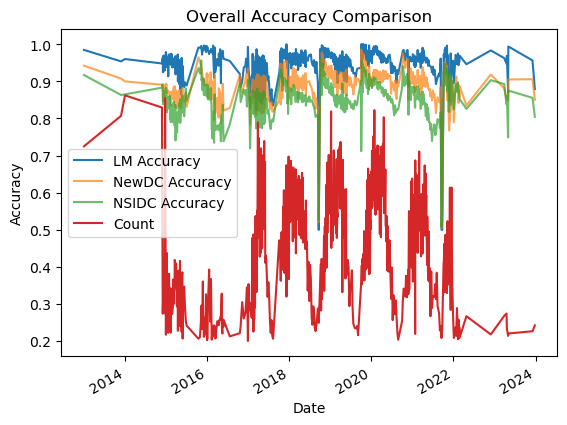

(528, 7)


In [6]:
warnings.filterwarnings('ignore', category=UserWarning)

scores['bac_lm'].plot(label='LM Accuracy', )
scores['bac_newdc'].plot(label='NewDC Accuracy', alpha=0.7)
scores['bac_nsidc'].plot(label='NSIDC Accuracy', alpha=0.7)
plt.plot(scores.index, scores['count'].values/10000, label='Count')
#plt.xlim(datetime(2019,11,1), datetime(2021,1,1))
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Overall Accuracy Comparison')
plt.show()
print(scores.shape)

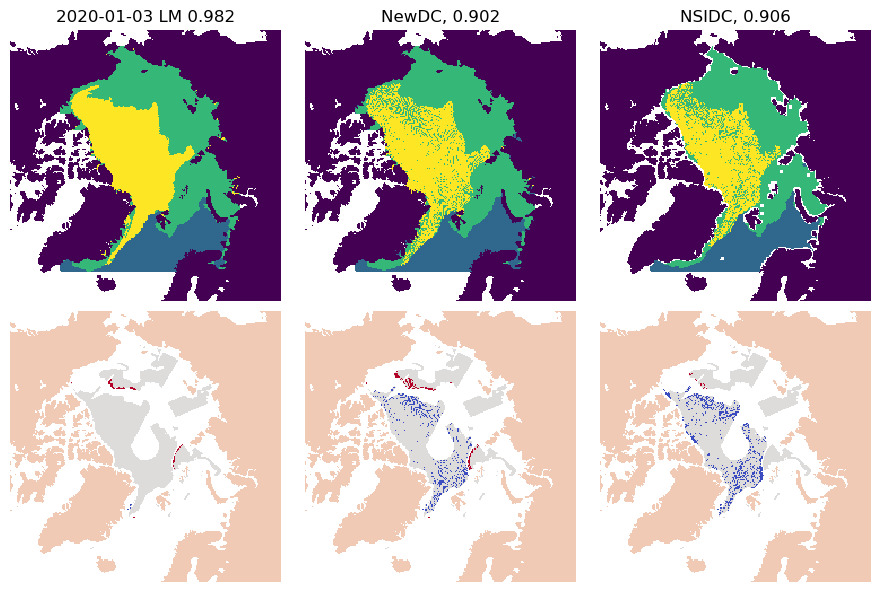

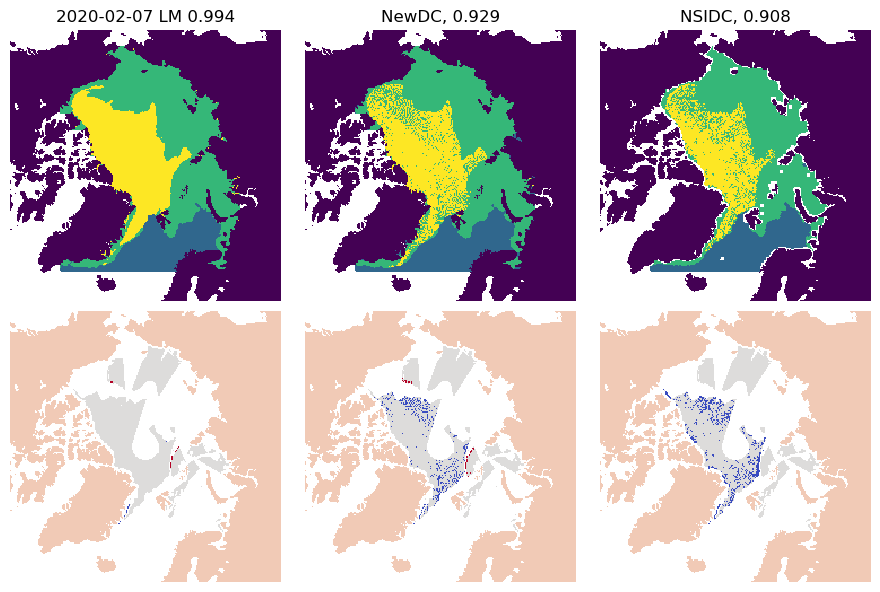

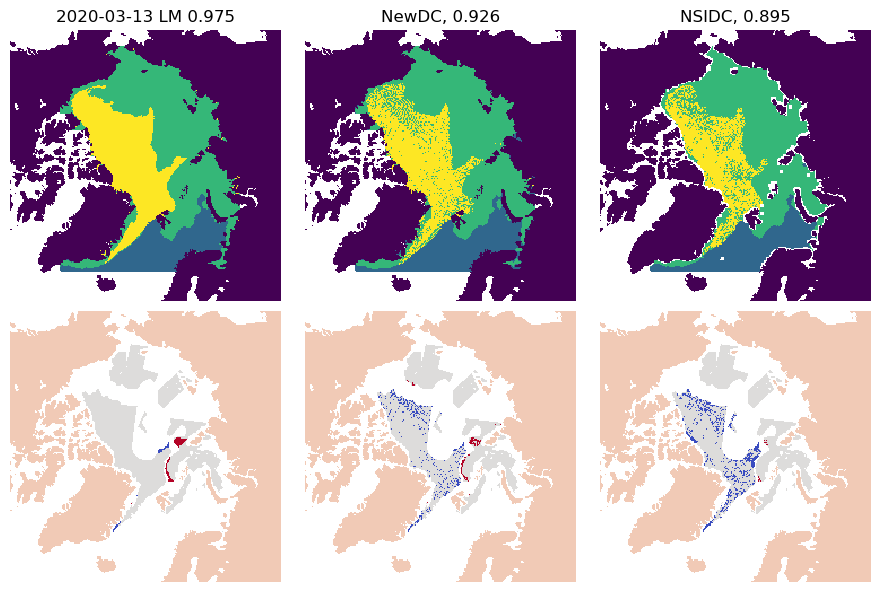

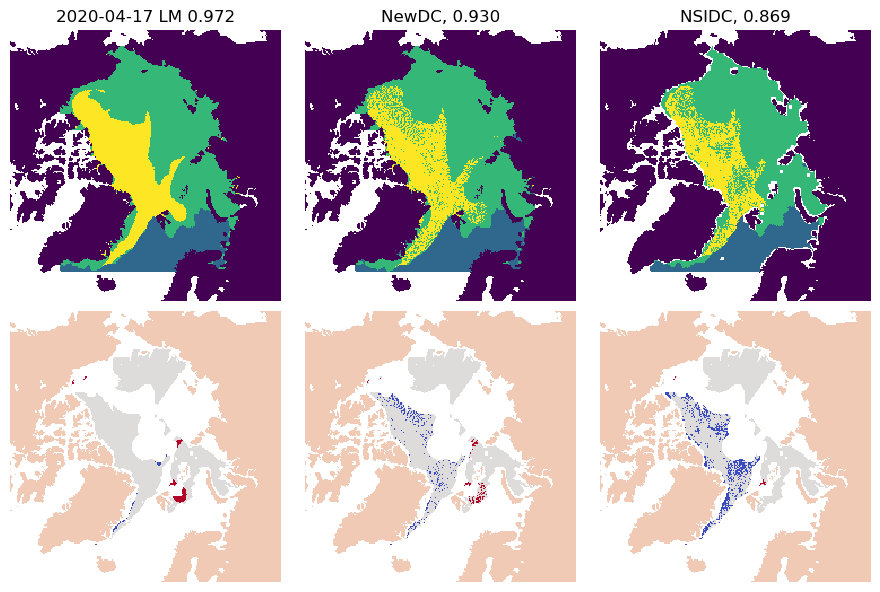

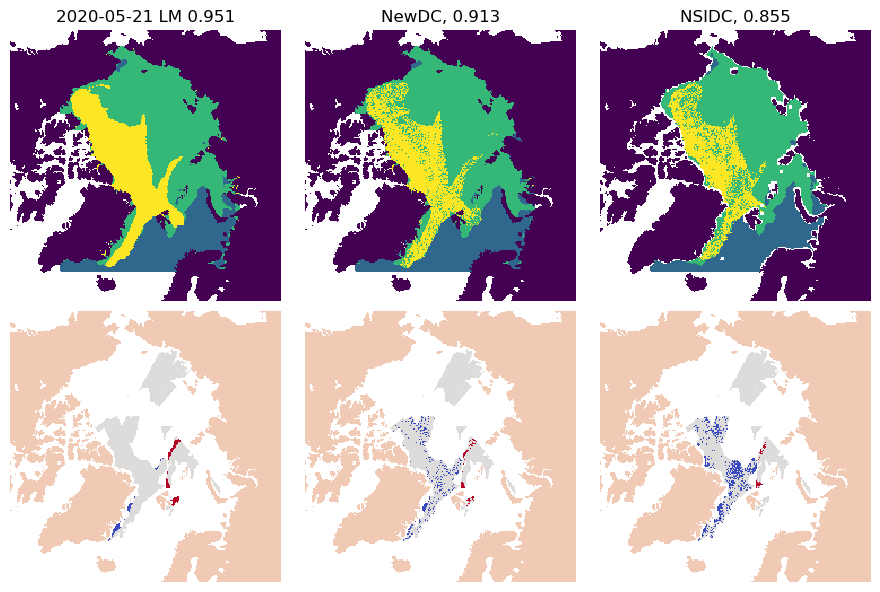

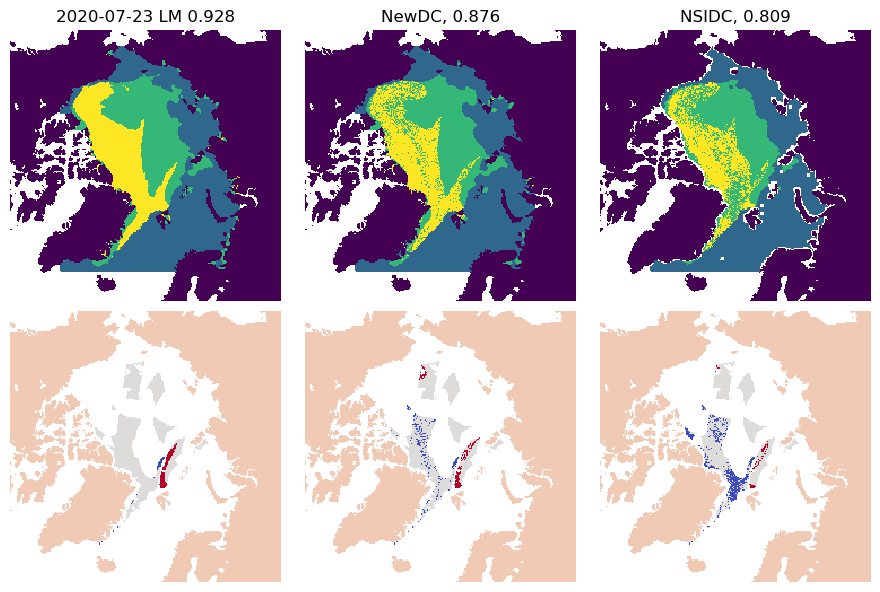

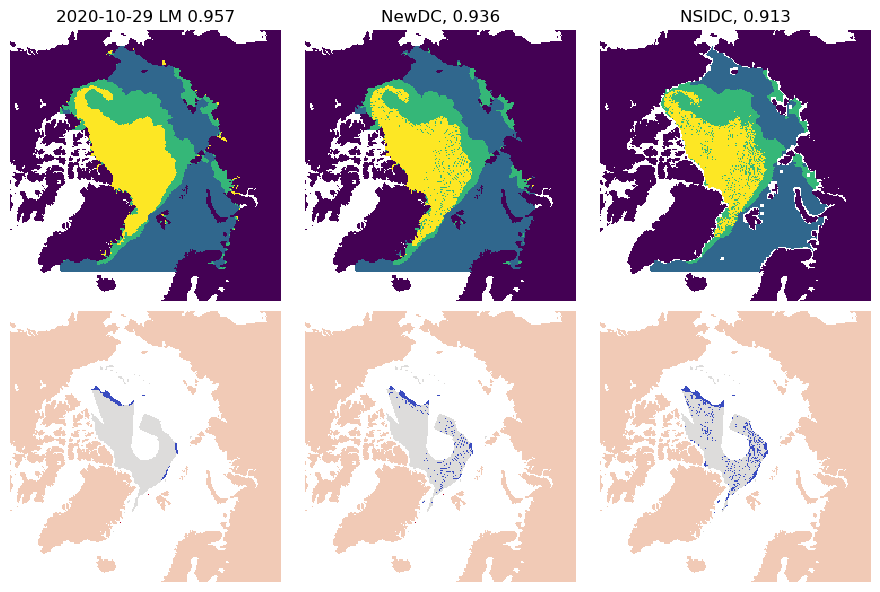

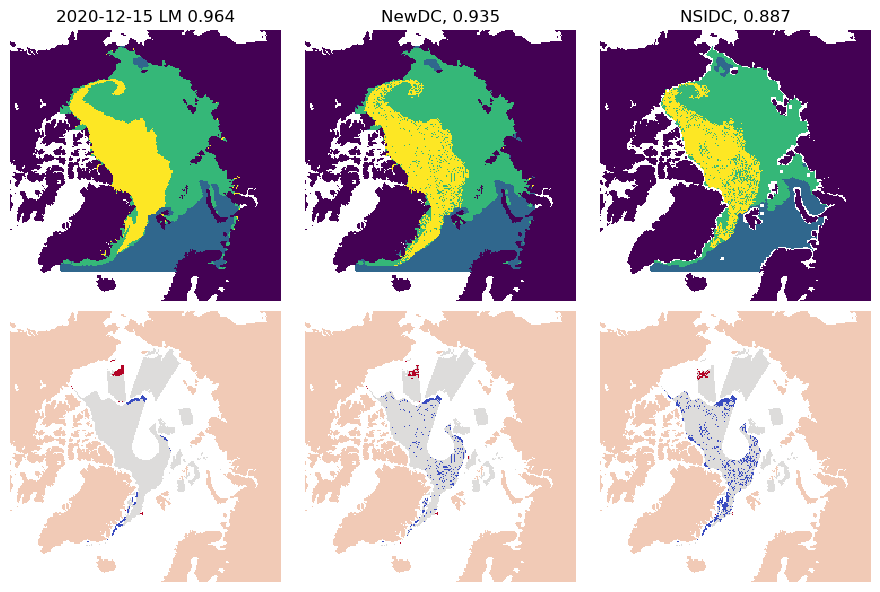

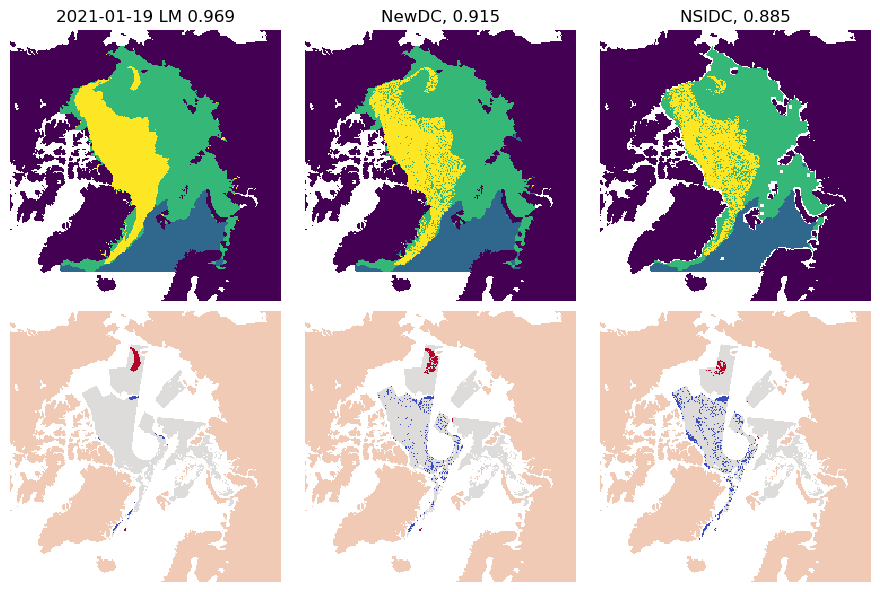

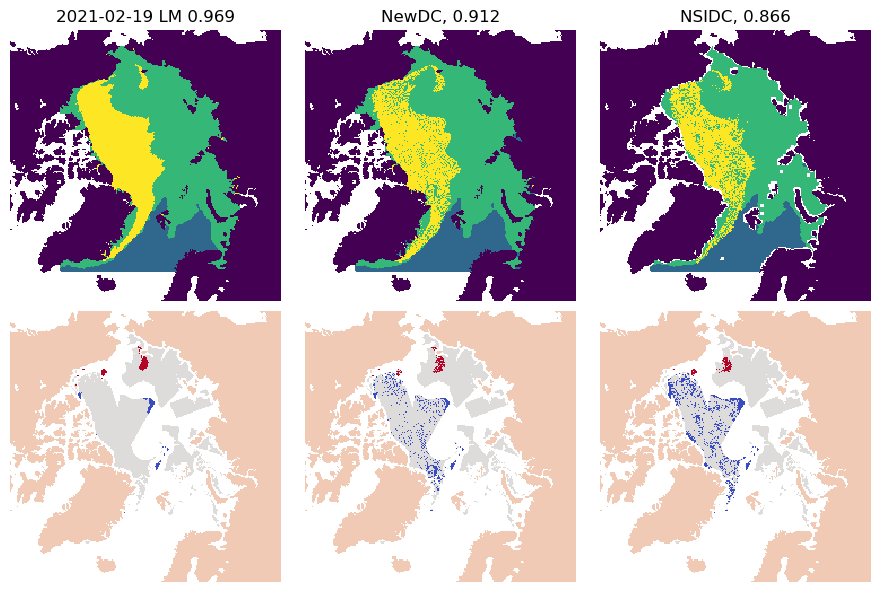

In [7]:
# rrdp_dates, rrdp_files, coll_files
plot_date_start = datetime(2020, 1, 1)
plot_dates = [d for d in scores.index if d >= plot_date_start][:100:10]
for plot_date in plot_dates:
    rf = rrdp_files[rrdp_dates.index(plot_date)]
    cf = coll_files[rrdp_dates.index(plot_date)]
    with xr.open_dataset(rf) as ds:
        icetype_matches = ds['icetype_matches'][0].values
    with xr.open_dataset(cf) as ds:
        lm_ice_type = ds['lm_ice_type'][0].values
        newdc_ice_type = ds['newdc_ice_type'][0].values
        nsidc_ice_type = ds['nsidc_ice_type'][0].values
        
    # convert to FYI/MYI only
    icetype_matches[icetype_matches == 1] = 2
    icetype_matches[icetype_matches == 3] = 4
    lm_ice_type[lm_ice_type == 3] = 4
    newdc_ice_type[newdc_ice_type == 3] = 4
    nsidc_ice_type[nsidc_ice_type == 3] = 4


    fig, axs = plt.subplots(2, 3, figsize=(9,6))    
    im0 = axs[0,0].imshow(lm_ice_type, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
    axs[0,0].set_title(f'{plot_date.strftime("%Y-%m-%d")} LM {scores.loc[plot_date].bac_lm:0.3f}')
    im1 = axs[0,1].imshow(newdc_ice_type, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
    axs[0,1].set_title(f'NewDC, {scores.loc[plot_date].bac_newdc:0.3f}')
    im2 = axs[0,2].imshow(nsidc_ice_type, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
    axs[0,2].set_title(f'NSIDC, {scores.loc[plot_date].bac_nsidc:0.3f}')

    coll_mask = np.isfinite(lm_ice_type) & (lm_ice_type > 0) & (newdc_ice_type > 0) & (nsidc_ice_type > 0)
    rrdp_mask = np.isfinite(icetype_matches) & (icetype_matches > 0)
    comm_mask = coll_mask & rrdp_mask
    landmask = lm_ice_type == -2
    lm_ice_type[~comm_mask] = np.nan
    newdc_ice_type[~comm_mask] = np.nan
    nsidc_ice_type[~comm_mask] = np.nan
    lm_ice_type[landmask] = -2
    newdc_ice_type[landmask] = -2
    nsidc_ice_type[landmask] = -2
    icetype_matches[landmask] = -2.4

    im3 = axs[1,0].imshow(lm_ice_type - icetype_matches, vmin=-2, vmax=2, cmap='coolwarm', interpolation='none')
    im4 = axs[1,1].imshow(newdc_ice_type - icetype_matches, vmin=-2, vmax=2, cmap='coolwarm', interpolation='none')
    im5 = axs[1,2].imshow(nsidc_ice_type - icetype_matches, vmin=-2, vmax=2, cmap='coolwarm', interpolation='none')
    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


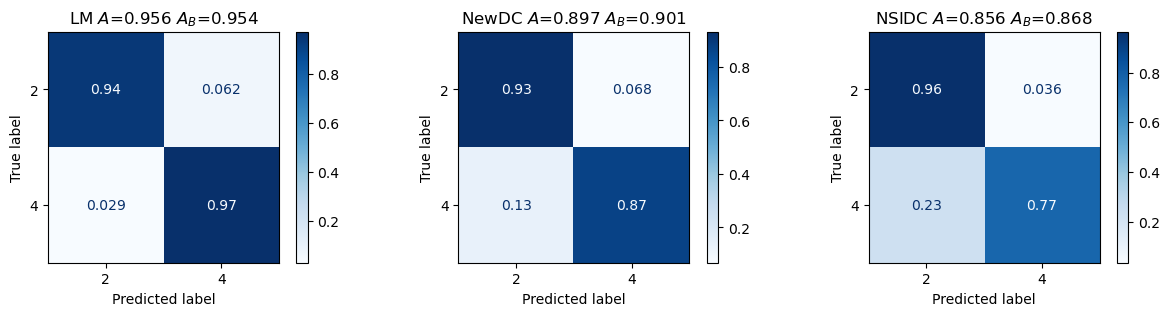

In [8]:
alg_labels = ['LM', 'NewDC', 'NSIDC']
fig, axs = plt.subplots(1, 3, figsize=(15,3))
for i in range(3):
    coma = comas[:, i].sum(axis=0)
    coma_normalized = coma.astype('float') / coma.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=coma_normalized, display_labels=[2, 4])
    disp.plot(ax=axs[i], cmap=plt.cm.Blues)
    accuracy = np.trace(coma) / np.sum(coma)
    balanced_accuracy = np.mean(np.diag(coma_normalized))
    axs[i].set_title(f'{alg_labels[i]} $A$={accuracy:0.3f} $A_B$={balanced_accuracy:0.3f}')
